In [1]:
import logging
import pprint
import time
import datetime

import tensorflow as tf
import keras as keras
import sklearn.model_selection
import sklearn.datasets
import numpy as np
import typing
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil



In [2]:
import logging
logging.basicConfig()
log = logging.getLogger(__name__)
log.setLevel(logging.ERROR)


# Setup

## Globals

In [3]:
default_params = {
  "optimizer" : "SGD",
  "batch_size" : 64,
  "activation_function" : "relu",
  "layer_sizes" : [4]
}

## Data

In [4]:
X_mc,y_mc = sklearn.datasets.make_classification(
  n_samples=10000,
  n_features=10,
  n_redundant=2,
  n_classes=3,
  n_clusters_per_class=1,
  class_sep=0.5
)

X_train_mc, X_test_mc, y_train_mc, y_test_mc = sklearn.model_selection.train_test_split(
  X_mc,
  y_mc,
  test_size=0.33,
  random_state=42
)

## Functions

In [5]:

def plot_multiple_histories(histories : typing.Dict, metric='loss', use_greyscale=True, show_validation=False, sort_agg_func=np.mean, sort_history_length=2, *args, **kwargs):
  """
  Plots the training history of multiple models on the same plot for comparison.
  
  Parameters:
    histories: List of History objects from multiple model's fit() calls.
    metric: The metric to plot ('loss', 'accuracy', etc.).
    labels: List of labels for the models. If None, defaults to 'Model 1', 'Model 2', etc.
  """
  # Check if labels are provided, otherwise generate default labels
  # if labels is None:
  #   labels = [f'Model {i+1}' for i in range(len(histories))]
  
  # Initialize the plot
  plt.figure(figsize=(10, 6))

  norm = plt.Normalize(vmin=0, vmax=len(histories))
  grayscale_cmap = plt.colormaps['gray']
  
  sorted_keys = sorted(histories.keys(), key=(lambda k: sort_agg_func(histories[k].history[metric][:-sort_history_length])))
  for i, label in enumerate(sorted_keys):
    history = histories[label]
    #for i, (label, history) in enumerate(histories.items()):
    epochs = range(1, len(history.history[metric]) + 1)
    
    # Plot training metric
    plt.plot(epochs, history.history[metric], label=f'{label} {metric.capitalize()}', color=grayscale_cmap(norm(i)))
    
    # Plot validation metric if available
    if show_validation and f'val_{metric}' in history.history:
      plt.plot(epochs, history.history[f'val_{metric}'], '--', label=f'{label} Validation {metric.capitalize()}', color=grayscale_cmap(norm(i)))
  
  # Add labels and title
  plt.title(f'Comparison of {metric.capitalize()} Between Models')
  plt.xlabel('Epochs')
  plt.ylabel(metric.capitalize())
  plt.legend()
  
  # Show plot
  plt.show()


In [6]:
def get_model(
        num_input_features=4, 
        activation_function="elu", 
        layer_sizes=None, 
        num_output_classes=3
):
  
  if layer_sizes is None:
    layer_sizes = [10]
  
  inputs = keras.layers.Input(shape=(num_input_features,)) 
  x = inputs
  for layer_size in layer_sizes:
    x = keras.layers.Dense(layer_size, activation=activation_function)(x)
  
  outputs = keras.layers.Dense(num_output_classes, activation='softmax')(x)
  return keras.models.Model(inputs=inputs, outputs=outputs)



In [7]:


def evaluate_params(params, verbose=1, num_epochs=10):
  
  # default parameters are used if not supplied
  pars = default_params.copy()
  pars.update(params)
  
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  
  model = get_model(
    num_input_features=X_train_mc.shape[1],
    activation_function=pars['activation_function'], 
    layer_sizes=pars['layer_sizes']
  )
  model.compile(
    optimizer=pars["optimizer"], 
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
  )
  
  history = model.fit(
    X_train_mc, 
    y_train_mc, 
    epochs=num_epochs, 
    callbacks=[early_stopping],
    batch_size=pars["batch_size"], 
    validation_split=0.3, 
    verbose=verbose
  )
  mean_acc = np.mean(history.history['val_accuracy'][-2:])
  
  return pars, mean_acc, history


Epoch 1/10


2024-10-14 11:30:43.880797: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-10-14 11:30:43.880828: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-10-14 11:30:43.880836: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-10-14 11:30:43.880851: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-14 11:30:43.880863: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-10-14 11:30:44.109580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2884 - loss: 1.4633 - val_accuracy: 0.3905 - val_loss: 1.1454
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4285 - loss: 1.0934 - val_accuracy: 0.5000 - val_loss: 0.9852
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5296 - loss: 0.9650 - val_accuracy: 0.5746 - val_loss: 0.9148
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5987 - loss: 0.8936 - val_accuracy: 0.6318 - val_loss: 0.8759
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6465 - loss: 0.8521 - val_accuracy: 0.6637 - val_loss: 0.8498
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6611 - loss: 0.8272 - val_accuracy: 0.6771 - val_loss: 0.8302
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6751 - loss: 0.8209 - val_accuracy: 0.6811 - val_loss: 0.8142
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6884 - loss: 0.8003 - val_accuracy: 0.6920 - val_loss: 0.8010
Epo

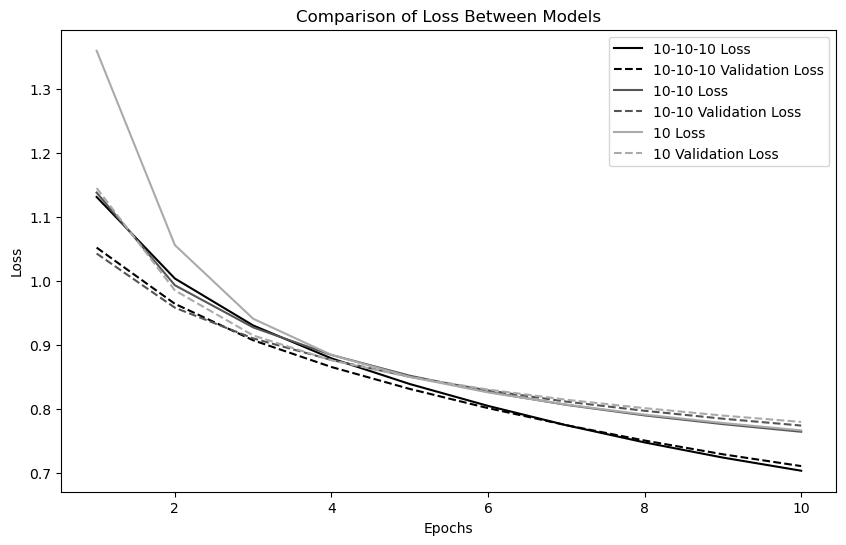

In [8]:
plot_multiple_histories({
    "10" : evaluate_params({
      "activation_function" : "elu",
      "layer_sizes" : [10]
    })[2],
    "10-10" : evaluate_params({
      "activation_function" : "elu",
      "layer_sizes" : [10, 10]
    })[2],
    "10-10-10" : evaluate_params({
      "activation_function" : "elu",
      "layer_sizes" : [10, 10, 10]
    })[2],
  },
  show_validation=True
)

# Search Approches


## Grid Search

In [9]:


def get_name(params):
  return '-'.join([str(params[key]) for key in sorted(params.keys())])

def grid_search(param_grid, verbose=1, num_epochs=10):
  
  # params_list = []
  # acc_list = []
  # history_list = []
  history_dict = {}
  for params in sklearn.model_selection.ParameterGrid(param_grid):
    print(f"params: {params}")
    pars, acc, history = evaluate_params(
      params, 
      verbose=verbose, 
      num_epochs=num_epochs
    )
    
    # params_list.append(pars)
    # acc_list.append(acc)
    # history_list.append(history)
    history_dict[get_name(pars)] = history
  
  return history_dict

params: {'activation_function': 'elu', 'batch_size': 128, 'layer_sizes': [10]}
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2420 - loss: 1.5980 - val_accuracy: 0.2473 - val_loss: 1.4055
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2708 - loss: 1.3539 - val_accuracy: 0.2811 - val_loss: 1.2412
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3256 - loss: 1.2030 - val_accuracy: 0.3299 - val_loss: 1.1372
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3946 - loss: 1.0936 - val_accuracy: 0.4095 - val_loss: 1.0669
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4433 - loss: 1.0423 - val_accuracy: 0.4672 - val_loss: 1.0157
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5102 - loss: 0.9941 - val_accuracy: 0.5174 - val_loss: 0.9766
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5514 - loss: 0.9555 - val_accuracy: 0.5627 - val_loss: 0.9457
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 

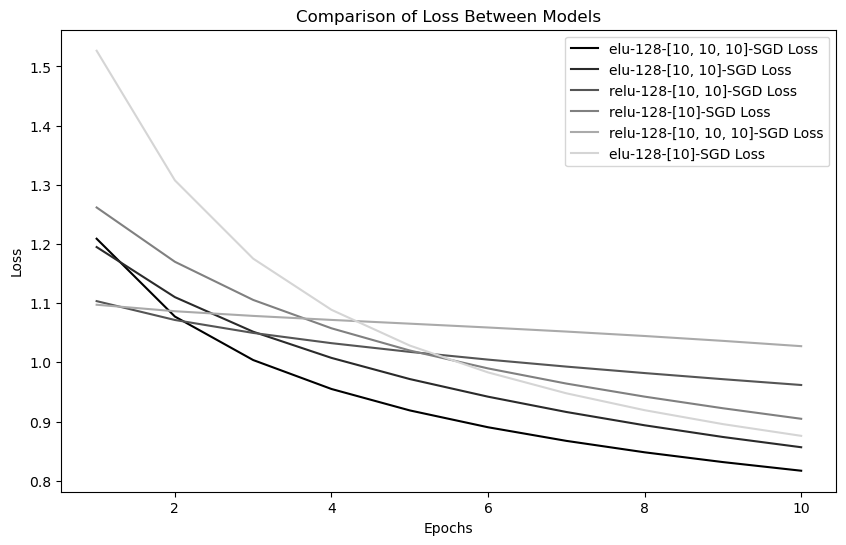

In [10]:
history_dict = grid_search(
  param_grid={
    "activation_function" : ["elu", "relu"],
    "layer_sizes" : [[10], [10, 10], [10,10,10]],
    "batch_size" : [128]
  },
  num_epochs=10
)
plot_multiple_histories(history_dict)


## Random Search

In [11]:
def random_search(
        param_grid, 
        num_tests=5, 
        random_state=None, 
        verbose=1, 
        num_epochs=10
):
  
  # create a list of unique parameter combinations
  param_combs = list(sklearn.model_selection.ParameterGrid(param_grid))
  if len(param_combs) < num_tests:
    num_tests = len(param_combs)
  random_combs = np.random.choice(param_combs, size=num_tests,
    replace=False)
  
  # evaluate each of the combinations
  history_dict = {}
  for params in random_combs:
    print(f"params: {params}")
    pars, acc, history = evaluate_params(params, verbose=verbose, num_epochs=num_epochs)
    
    history_dict[get_name(pars)] = history
  return history_dict

params: {'activation_function': 'elu', 'batch_size': 128, 'layer_sizes': [10]}
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4848 - loss: 1.0546 - val_accuracy: 0.4940 - val_loss: 1.0312
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4938 - loss: 1.0366 - val_accuracy: 0.5239 - val_loss: 0.9908
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5444 - loss: 0.9781 - val_accuracy: 0.5542 - val_loss: 0.9623
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5738 - loss: 0.9392 - val_accuracy: 0.5756 - val_loss: 0.9415
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5867 - loss: 0.9320 - val_accuracy: 0.5985 - val_loss: 0.9256
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6075 - loss: 0.9044 - val_accuracy: 0.6085 - val_loss: 0.9129
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6032 - loss: 0.9178 - val_accuracy: 0.6214 - val_loss: 0.9023
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 

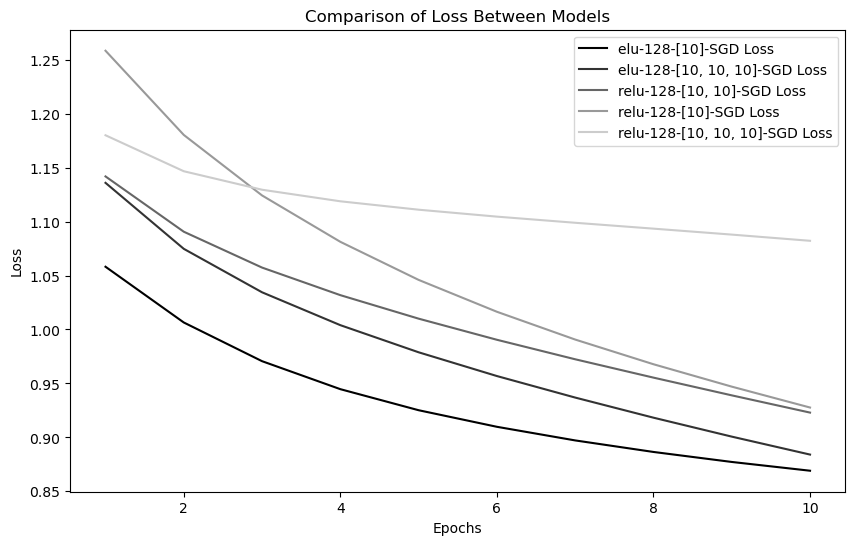

In [12]:
 history_dict = random_search(
  param_grid={
    "activation_function" : ["elu", "relu"],
    "layer_sizes" : [[10], [10, 10], [10,10,10]],
    "batch_size" : [128]
  }
)
plot_multiple_histories(history_dict, sort_key="accuracy")

params: {'activation_function': 'relu', 'batch_size': 128, 'layer_sizes': [1, 1]}
Epoch 1/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2796 - loss: 1.2928 - val_accuracy: 0.2786 - val_loss: 1.1927
Epoch 2/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2893 - loss: 1.1704 - val_accuracy: 0.2995 - val_loss: 1.1416
Epoch 3/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3094 - loss: 1.1334 - val_accuracy: 0.3214 - val_loss: 1.1206
Epoch 4/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3146 - loss: 1.1131 - val_accuracy: 0.3308 - val_loss: 1.1105
Epoch 5/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3308 - loss: 1.1034 - val_accuracy: 0.3373 - val_loss: 1.1048
Epoch 6/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3319 - loss: 1.1021 - val_accuracy: 0.3493 - val_loss: 1.1013
Epoch 7/200
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3439 - loss: 1.0991 - val_accuracy: 0.3493 - val_loss: 1.0990
Epoch 8/200
37/37 ━━━━━━━━━━

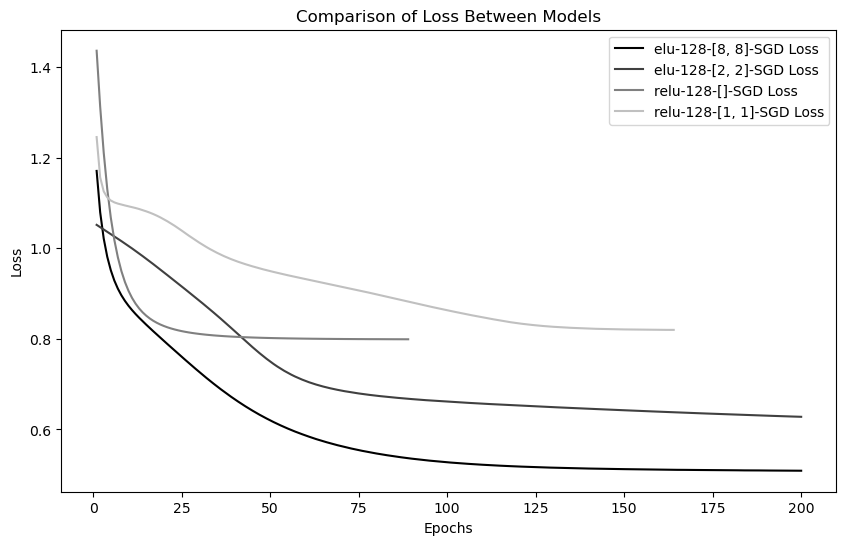

In [13]:
history_dict = random_search(
  param_grid={
    "activation_function" : ["elu", "relu"],
    "layer_sizes" : [[2**layer_size] * num_layers for layer_size in range(0,5) for num_layers in range(0,4)],
    "batch_size" : [128]
  },
  num_epochs=200,
  num_tests=4
)

plot_multiple_histories(history_dict)

## Grid Search with logger

In [14]:
import logging

class TuningLogger:
  default_log_dir = "logs/"
  
  def __init__(self, log_dir=None):
    
    current_time = datetime.datetime.now()
    self.id = current_time.strftime("%d%b%Y-%H-%M-%S-%f")   # hour, minute, microseconds
    
    self.logger = logging.getLogger("TuningLogger")
    self.logger.setLevel(logging.INFO)
    
    if self.logger.hasHandlers():
      self.logger.handlers.clear()
    self.logger.propagate = False
    
    if log_dir is None:
      log_dir = self.__class__.default_log_dir
      
    if not os.path.exists(log_dir):
      os.mkdir(log_dir)
    
    log_path = os.path.join(log_dir, f"{self.__class__.__name__}-{self.id}.log")
    
    file_handler = logging.FileHandler(log_path)
    file_handler.setFormatter(logging.Formatter('%(message)s'))
    self.logger.addHandler(file_handler)
  
  def log_trial(self, params, history, metrics=["loss"], agg_history=3):
    report = {
      "id": self.id,
      "time": time.time(), # time since epoch
    }
    report.update(params)
    for metric in metrics:
      report[metric] = np.mean(history.history[metric][:-agg_history])
    self.logger.info(report)
    return


In [15]:

def grid_search_logging(param_grid, verbose=1, num_epochs=10, log_results=True):
  
  tuning_logger = TuningLogger()
  
  history_dict = {}
  for params in sklearn.model_selection.ParameterGrid(param_grid):
    print(f"params: {params}")
    pars, acc, history = evaluate_params(params, verbose=verbose, num_epochs=num_epochs)
    if log_results:
      tuning_logger.log_trial(pars, history)
    history_dict[get_name(pars)] = history
  
  return history_dict
  


params: {'activation_function': 'elu', 'batch_size': 32, 'layer_sizes': [8, 8]}
Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4319 - loss: 1.0587 - val_accuracy: 0.5100 - val_loss: 0.9890
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5400 - loss: 0.9554 - val_accuracy: 0.5697 - val_loss: 0.9325
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5890 - loss: 0.9030 - val_accuracy: 0.6159 - val_loss: 0.8832
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6231 - loss: 0.8520 - val_accuracy: 0.6537 - val_loss: 0.8357
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6810 - loss: 0.7954 - val_accuracy: 0.6811 - val_loss: 0.7933
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6868 - loss: 0.7588 - val_accuracy: 0.6995 - val_loss: 0.7573
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7119 - loss: 0.7168 - val_accuracy: 0.7060 - val_loss: 0.7287
Epoch 8/100
147/1

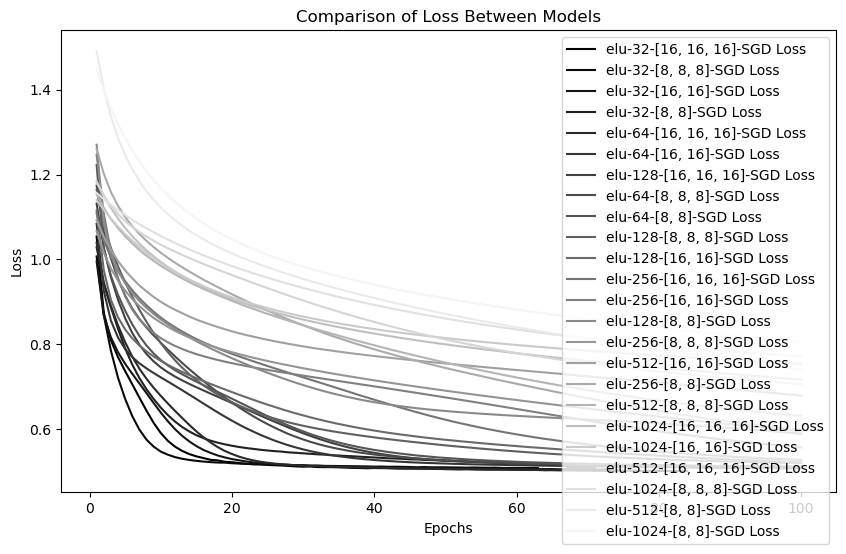

In [16]:
history_dict = grid_search_logging(
  param_grid={
    "activation_function" : ["elu"], #["elu", "relu"],
    "layer_sizes" : [[2**layer_size] * num_layers for layer_size in range(3,5) for num_layers in range(2,4)],
    "batch_size" : [2**batch_exponent for batch_exponent in range(5,11)]
  },
  num_epochs=100
)
plot_multiple_histories(history_dict)

# Optuna

In [17]:
import optuna

In [18]:

def objective(trial):
  # params = default_params
  
  layer_size = trial.suggest_int("layer_size", 3, 5)
  num_layers = trial.suggest_int("num_layers", 2, 4)
  batch_exponent = trial.suggest_int("batch_exponent", 5, 11)
  params = {
    "activation_function" : trial.suggest_categorical("activation", ["elu"]),
    "layer_sizes" : [2**layer_size for _ in range(num_layers)],
    "batch_size" : 2**batch_exponent
  }
  pars, acc, history = evaluate_params(params)
  return acc
  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

best_trial = study.best_trial
print(best_trial.values[0])
print(best_trial.params)


[I 2024-10-14 11:51:03,571] A new study created in memory with name: no-name-865d10e5-d69c-4891-a6f1-18bc0b727604


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4824 - loss: 1.0390 - val_accuracy: 0.6692 - val_loss: 0.8569
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6869 - loss: 0.8241 - val_accuracy: 0.6861 - val_loss: 0.8040
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7203 - loss: 0.7763 - val_accuracy: 0.6970 - val_loss: 0.7759
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7112 - loss: 0.7473 - val_accuracy: 0.6985 - val_loss: 0.7506
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7125 - loss: 0.7222 - val_accuracy: 0.7025 - val_loss: 0.7237
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7067 - loss: 0.7017 - val_accuracy: 0.7070 - val_loss: 0.6928
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7270 - loss: 0.6493 - val_accuracy: 0.7139 - val_loss: 0.6583
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7114 - loss: 0.6435 - val_accuracy: 0

[I 2024-10-14 11:51:17,935] Trial 0 finished with value: 0.7313432991504669 and parameters: {'layer_size': 5, 'num_layers': 3, 'batch_exponent': 5, 'activation': 'elu'}. Best is trial 0 with value: 0.7313432991504669.


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.3489 - loss: 1.1604 - val_accuracy: 0.4100 - val_loss: 1.0875
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4001 - loss: 1.0877 - val_accuracy: 0.4567 - val_loss: 1.0380
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4391 - loss: 1.0423 - val_accuracy: 0.4980 - val_loss: 1.0006
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4741 - loss: 1.0027 - val_accuracy: 0.5174 - val_loss: 0.9716
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4991 - loss: 0.9774 - val_accuracy: 0.5473 - val_loss: 0.9482
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5446 - loss: 0.9494 - val_accuracy: 0.5721 - val_loss: 0.9295
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5715 - loss: 0.9231 - val_accuracy: 0.5940 - val_loss: 0.9137
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5972 - loss: 0.9078 - val_accuracy: 0.6055 - val_l

[I 2024-10-14 11:51:19,618] Trial 1 finished with value: 0.6236318349838257 and parameters: {'layer_size': 5, 'num_layers': 2, 'batch_exponent': 9, 'activation': 'elu'}. Best is trial 0 with value: 0.7313432991504669.


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3914 - loss: 1.1089 - val_accuracy: 0.5264 - val_loss: 0.9975
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5459 - loss: 0.9761 - val_accuracy: 0.5881 - val_loss: 0.9333
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6053 - loss: 0.9106 - val_accuracy: 0.6264 - val_loss: 0.8869
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6317 - loss: 0.8755 - val_accuracy: 0.6498 - val_loss: 0.8495
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6585 - loss: 0.8225 - val_accuracy: 0.6592 - val_loss: 0.8187
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6753 - loss: 0.7964 - val_accuracy: 0.6667 - val_loss: 0.7913
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6811 - loss: 0.7714 - val_accuracy: 0.6751 - val_loss: 0.7670
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6749 - loss: 0.7546 - val_accuracy: 0.6816 - val_loss

[I 2024-10-14 11:51:27,055] Trial 2 finished with value: 0.689303457736969 and parameters: {'layer_size': 3, 'num_layers': 3, 'batch_exponent': 6, 'activation': 'elu'}. Best is trial 0 with value: 0.7313432991504669.


Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4872 - loss: 1.0228 - val_accuracy: 0.5448 - val_loss: 0.9459
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5695 - loss: 0.9258 - val_accuracy: 0.6070 - val_loss: 0.8904
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6195 - loss: 0.8803 - val_accuracy: 0.6522 - val_loss: 0.8557
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6565 - loss: 0.8434 - val_accuracy: 0.6701 - val_loss: 0.8307
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6675 - loss: 0.8267 - val_accuracy: 0.6826 - val_loss: 0.8120
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6961 - loss: 0.7876 - val_accuracy: 0.6886 - val_loss: 0.7967
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6898 - loss: 0.7821 - val_accuracy: 0.6910 - val_loss: 0.7843
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7065 - loss: 0.7594 - val_accuracy: 0.6965 - val_loss

[I 2024-10-14 11:51:33,198] Trial 3 finished with value: 0.6955223977565765 and parameters: {'layer_size': 4, 'num_layers': 2, 'batch_exponent': 6, 'activation': 'elu'}. Best is trial 0 with value: 0.7313432991504669.


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3982 - loss: 1.1476 - val_accuracy: 0.4637 - val_loss: 1.0390
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4767 - loss: 1.0221 - val_accuracy: 0.5303 - val_loss: 0.9646
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5391 - loss: 0.9498 - val_accuracy: 0.5851 - val_loss: 0.9221
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6037 - loss: 0.8920 - val_accuracy: 0.6159 - val_loss: 0.8941
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6246 - loss: 0.8730 - val_accuracy: 0.6274 - val_loss: 0.8738
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6444 - loss: 0.8504 - val_accuracy: 0.6438 - val_loss: 0.8578
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6568 - loss: 0.8357 - val_accuracy: 0.6522 - val_loss: 0.8444
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6592 - loss: 0.8282 - val_accuracy: 0.6562 - val_loss

[I 2024-10-14 11:51:36,813] Trial 4 finished with value: 0.6666666567325592 and parameters: {'layer_size': 3, 'num_layers': 2, 'batch_exponent': 7, 'activation': 'elu'}. Best is trial 0 with value: 0.7313432991504669.


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.1992 - loss: 1.2949 - val_accuracy: 0.2109 - val_loss: 1.2379
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2100 - loss: 1.2329 - val_accuracy: 0.2323 - val_loss: 1.1883
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2423 - loss: 1.1818 - val_accuracy: 0.2716 - val_loss: 1.1476
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2718 - loss: 1.1454 - val_accuracy: 0.3284 - val_loss: 1.1136
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3294 - loss: 1.1113 - val_accuracy: 0.3741 - val_loss: 1.0845
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3677 - loss: 1.0841 - val_accuracy: 0.4139 - val_loss: 1.0595
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4208 - loss: 1.0576 - val_accuracy: 0.4582 - val_loss: 1.0377
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4670 - loss: 1.0338 - val_accuracy: 0.4925 - val_loss: 1.0184


[I 2024-10-14 11:51:38,321] Trial 5 finished with value: 0.5358209013938904 and parameters: {'layer_size': 5, 'num_layers': 3, 'batch_exponent': 10, 'activation': 'elu'}. Best is trial 0 with value: 0.7313432991504669.


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3522 - loss: 1.1739 - val_accuracy: 0.5368 - val_loss: 0.9809
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5561 - loss: 0.9435 - val_accuracy: 0.5786 - val_loss: 0.9121
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5987 - loss: 0.8914 - val_accuracy: 0.6323 - val_loss: 0.8710
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6548 - loss: 0.8403 - val_accuracy: 0.6657 - val_loss: 0.8316
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6863 - loss: 0.7974 - val_accuracy: 0.6900 - val_loss: 0.7924
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6876 - loss: 0.7684 - val_accuracy: 0.7045 - val_loss: 0.7566
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7027 - loss: 0.7284 - val_accuracy: 0.7134 - val_loss: 0.7261
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7166 - loss: 0.6976 - val_accuracy: 0.

[I 2024-10-14 11:51:49,519] Trial 6 finished with value: 0.7184079587459564 and parameters: {'layer_size': 3, 'num_layers': 2, 'batch_exponent': 5, 'activation': 'elu'}. Best is trial 0 with value: 0.7313432991504669.


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.2514 - loss: 1.1915 - val_accuracy: 0.2846 - val_loss: 1.1657
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2698 - loss: 1.1741 - val_accuracy: 0.3070 - val_loss: 1.1480
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3056 - loss: 1.1514 - val_accuracy: 0.3318 - val_loss: 1.1318
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3293 - loss: 1.1353 - val_accuracy: 0.3562 - val_loss: 1.1167
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3530 - loss: 1.1205 - val_accuracy: 0.3786 - val_loss: 1.1026
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3687 - loss: 1.1068 - val_accuracy: 0.3950 - val_loss: 1.0896
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3893 - loss: 1.0930 - val_accuracy: 0.4174 - val_loss: 1.0773
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4131 - loss: 1.0768 - val_accuracy: 0.4368 - val_loss: 1.0659

[I 2024-10-14 11:51:51,186] Trial 7 finished with value: 0.45398010313510895 and parameters: {'layer_size': 5, 'num_layers': 4, 'batch_exponent': 11, 'activation': 'elu'}. Best is trial 0 with value: 0.7313432991504669.


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.2594 - loss: 1.4377 - val_accuracy: 0.2980 - val_loss: 1.3435
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2798 - loss: 1.3236 - val_accuracy: 0.3119 - val_loss: 1.2688
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2988 - loss: 1.2558 - val_accuracy: 0.3279 - val_loss: 1.2156
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3193 - loss: 1.2098 - val_accuracy: 0.3473 - val_loss: 1.1750
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3348 - loss: 1.1608 - val_accuracy: 0.3642 - val_loss: 1.1431
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3535 - loss: 1.1374 - val_accuracy: 0.3801 - val_loss: 1.1177
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3724 - loss: 1.1052 - val_accuracy: 0.3990 - val_loss: 1.0968
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3905 - loss: 1.0885 - val_accuracy: 0.4114 - val_loss: 1.0788

[I 2024-10-14 11:51:53,036] Trial 8 finished with value: 0.4345771074295044 and parameters: {'layer_size': 4, 'num_layers': 4, 'batch_exponent': 10, 'activation': 'elu'}. Best is trial 0 with value: 0.7313432991504669.


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.3188 - loss: 1.2413 - val_accuracy: 0.3119 - val_loss: 1.2144
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3300 - loss: 1.2090 - val_accuracy: 0.3274 - val_loss: 1.1868
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3471 - loss: 1.1761 - val_accuracy: 0.3408 - val_loss: 1.1621
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3585 - loss: 1.1520 - val_accuracy: 0.3592 - val_loss: 1.1400
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3661 - loss: 1.1313 - val_accuracy: 0.3716 - val_loss: 1.1197
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3815 - loss: 1.1079 - val_accuracy: 0.3826 - val_loss: 1.1010
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3897 - loss: 1.0923 - val_accuracy: 0.3985 - val_loss: 1.0840
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4027 - loss: 1.0740 - val_accuracy: 0.4100 - val_loss: 1.0681

[I 2024-10-14 11:51:54,243] Trial 9 finished with value: 0.43208955228328705 and parameters: {'layer_size': 5, 'num_layers': 4, 'batch_exponent': 11, 'activation': 'elu'}. Best is trial 0 with value: 0.7313432991504669.


0.7313432991504669
{'layer_size': 5, 'num_layers': 3, 'batch_exponent': 5, 'activation': 'elu'}
